# [CoE202] note 07b. Neural Network MNIST classification (Pytorch)

- Class Date : 21.05.06.
- Office Hour : -----------
- If you have any questions, ask via KLMS Q&A board or come to TA office hour to get our help.

In [2]:
# this is just an annotation
import numpy as np # this is for importing numpy library (and we will use abbreviation np for that)
import matplotlib.pyplot as plt # this is for importing matplotlib.pyplot (library for graph plot)
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [3]:
# Set hyperparameters and settings.
# ACTIVITY  : you might want to try different hyper-parameters
batch_size = 512
n_iter = 200
learning_rate = 0.002

seed = 1

torch.manual_seed(seed) # by setting this, things will become reproducible (nothing is  random)

useGPU = torch.cuda.is_available()
print(useGPU)
device = torch.device("cuda" if useGPU else "cpu")

False


## 1. Load dataset (MNIST) and split into train, valid and test set

In [4]:
# load MNIST data
train_dataset = torchvision.datasets.MNIST("../mnist_data/",
                                               download=True,
                                               train=True,
                                               transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                               ]))

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

test_dataset = torchvision.datasets.MNIST("../mnist_data/",
                                              download=True,
                                              train=False,
                                              transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                              ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable

100.0%
Extracting ../mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable

102.8%
Extracting ../mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable

100.0%
Extracting ../mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../mnist_data/MNIST/raw

112.7%Extracting ../mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../mnist_data/MNIST/raw

Processing...
Done!

/usr/local/anaconda3/envs/KAIST-CoE202/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable be

In [5]:
[one_batch_data, one_batch_label] = next(iter(train_loader))
print(one_batch_data.size(), one_batch_label.size())

torch.Size([512, 1, 28, 28]) torch.Size([512])


## 2. Visualization

In [6]:
# define a function to plot data
def show_data(data, label):
    # data shape : torch.Size([Batch_size, 1, 28, 28])
    # label shape : torch.Size([4])
    num_row = 2
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col)
    for i in range(8):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(data[i, 0].cpu(), cmap='gray')
        ax.set_title(f'label : {label[i].cpu().item()}')
    plt.tight_layout()
    plt.show()

ground truth example


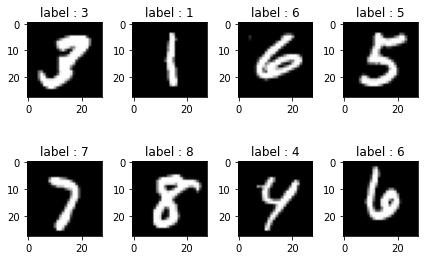

In [7]:
# show ground truth classification (one batch)
print('ground truth example')
show_data(one_batch_data, one_batch_label)

## 3. Define MLP classifier and show initial classification
#### make image to 1-dimensional vector by torch.view() and use 3 Linear layer.

In [ ]:
# Define MLP classifier
class mlp_classifier(nn.Module):
    '''2 Layer Multi-Layer Perceptron can be easily implemented by Linear layer of Pytorch.
    The linear layer has weight matrix and bias matrix. We will first initialize this weight and bias
    as following normal distribution, by 'weights_init' function. 
    '''
    # initialization
    def __init__(self):
        super(mlp_classifier, self).__init__()
        #################################################################################
        # ACTIVITY  : fill in this part 
        self.layer1 = # nn.Linear? 
        self.layer2 = # nn.Linear?
        self.layer3 = # nn.Linear?
        self.relu = nn.ReLU()
        #################################################################################
    
    # forward path
    def forward(self, x):
        #################################################################################
        # ACTIVITY  : fill in this part 
        # Make 2D image to 1D vector and we can use Linear layer (Fully-connected layer)
        x = x.view(-1, 28*28)          
        x = # layer1  
        x = # relu
        x = # layer2  
        x = # relu
        x = # layer3  

        return x
        #################################################################################

def thresholding(prediction):
    # Find label which shows highest prediction value
    _, pred_label = torch.max(prediction, 1)

    return pred_label

In [ ]:
my_classifier = mlp_classifier()  # assign classifier
if useGPU:
    my_classifier = my_classifier.to(device)


# show the performance of untrained classifier
print('current classification')
if useGPU:
    prediction = my_classifier(one_batch_data.to(device))  # passing forward function of classifier, return prediction
else:
     prediction = my_classifier(one_batch_data)  # passing forward function of classifier, return prediction
     
show_data(one_batch_data, thresholding(prediction))  # Initialize success, output is all zero!

## 4. Train MLP classifier and monitor loss and accuracy for train, valid and test set

In [ ]:
#  numpy arrays to save loss & accuracy from each epoch
train_loss_iter = np.zeros(n_iter, dtype=float)  # Temporary numpy array to save loss for each epoch
valid_loss_iter = np.zeros(n_iter, dtype=float)
train_accuracy_iter = np.zeros(n_iter, dtype=float)  # Temporary numpy array to save accuracy for each epoch
valid_accuracy_iter = np.zeros(n_iter, dtype=float)

# We are going to use Binary cross entropy loss (built in Pytorch!)
criterion = torch.nn.CrossEntropyLoss()


# We can use either SGD or Adam (and there are other choices as well)
optimizer = torch.optim.SGD(my_classifier.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(my_classifier.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


# main iteration
for iteration in range(n_iter):  

    # Training
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0 # initialize a few variabels

    for batch_idx, (x, target) in enumerate(train_loader): # for each mini-batch
        if useGPU:
            x, target = x.cuda(), target.cuda()              

        prediction = my_classifier(x)  # Forward pass (of a mini-batch of training data)
        
        optimizer.zero_grad()  # Pytorch does not overwrite gradients, but it 'accumulates' them. Thus, we need to set gradient as 0 before we start.
        loss = criterion(prediction, target)   # Calculate cross-entropy loss 
        loss.backward()  # Pytorch automatically performs back-propagation to calculate gradients
        optimizer.step() # Using the optimizer and the calculated gradients, update parameters of classifier 

        total_loss += loss.item() # accumulate loss
        total_cnt += x.data.size(0) # accumulate the number of data
        correct_cnt += (thresholding(prediction) == target.data).sum().item() # accumulate the number of correct predictions
   
    accuracy = correct_cnt * 1.0 / total_cnt  # calculate accuracy  (#accumulated-correct-prediction/#accumulated-data)
    train_loss_iter[iteration] = total_loss / total_cnt # calculate and save loss (#accumulated-loss/#accumulated-data)
    train_accuracy_iter[iteration] = accuracy  # save accuracy
        

    # Validation
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0 # initialize a few variabels
    for batch_idx, (x, target) in enumerate(valid_loader):  # for each mini-batch
        with torch.no_grad(): # we do not need to calculation gradient for validation data
            if useGPU:
                x, target = x.cuda(), target.cuda()
            
            prediction = my_classifier(x) # Forward pass (of a mini-batch of validation data)
            loss = criterion(prediction, target) # Calculate cross-entropy loss 

            total_loss += loss.item() # accumulate loss
            total_cnt += x.data.size(0) # accumulate the number of data
            correct_cnt += (thresholding(prediction) == target.data).sum().item()  # accumulate the number of correct predictions
    
    accuracy = correct_cnt * 1.0 / total_cnt  # calculate accuracy  (#accumulated-correct-prediction/#accumulated-data)
    valid_loss_iter[iteration]  = total_loss / total_cnt  # calculate and save loss (#accumulated-loss/#accumulated-data)
    valid_accuracy_iter[iteration] = accuracy # save accuracy

    # print message every 10 epochs
    if iteration % 10 == 0:
        print(f"[{iteration}/{n_iter}] Train Loss : {train_loss_iter[iteration]:.4f} Train Acc : {train_accuracy_iter[iteration]:.2f} \
        Valid Loss : {valid_loss_iter[iteration]:.4f} Valid Acc : {valid_accuracy_iter[iteration]:.2f}")

## 5-1. Plot loss and accuracy of train, valid and test set for epoch

In [ ]:
# plot loss curve
l1, = plt.semilogy(range(1,n_iter+1), train_loss_iter)
l2, = plt.semilogy(range(1,n_iter+1), valid_loss_iter)
plt.legend([l1, l2], ["Train loss", "Valid loss"])

In [ ]:
# plot accuracy curve
l1, = plt.plot(range(1,n_iter+1), 100*train_accuracy_iter)
l2, = plt.plot(range(1,n_iter+1), 100*valid_accuracy_iter)

plt.legend([l1, l2], ["Train Acc", "Valid Acc"])

## 5-2. Visualize classification result of test set after training

In [ ]:
# For test data
print('After training')
[one_batch_data, one_batch_label] = next(iter(test_loader))
if useGPU:
    prediction = my_classifier(one_batch_data.to(device))
else:
    prediction = my_classifier(one_batch_data)
show_data(one_batch_data, thresholding(prediction))